# Indexing in Vector Databases (1) - Locality Sensitive Hashing (LSH)

> **📖 Interactive Learning Guide**: This notebook provides a comprehensive introduction to Locality Sensitive Hashing (LSH) with theory, mathematical formulations, and hands-on Python examples. Use the **Table of Contents** below to navigate directly to any section of interest.

## 📚 Table of Contents

### Core Concepts
1. [Locality Sensitive Hashing (LSH)](#1-locality-sensitive-hashing-lsh)
2. [Open Source Methods](#2-open-source-methods)
3. [Semantic Hashing](#3-semantic-hashing)
4. [How LSH Works: The Core Mechanism](#4-how-lsh-works-the-core-mechanism)

### LSH Techniques & Examples
5. [MinHash LSH: For Set Similarity (Jaccard Index)](#5-minhash-lsh-for-set-similarity-jaccard-index)
   - [Example 1: Random Hyperplane LSH for Cosine Similarity](#example-1-random-hyperplane-lsh-for-cosine-similarity)
   - [Example 2: MinHash LSH for Document Similarity](#example-2-minhash-lsh-for-document-similarity)

6. [LSH Performance Analysis](#6-lsh-performance-analysis)
   - [Example 3: LSH Performance Analysis](#example-3-lsh-performance-analysis)
   - [Example 4: Visualizing LSH Behavior](#example-4-visualizing-lsh-behavior)
   - [Example 5: Practical LSH for High-Dimensional Vectors](#example-5-practical-lsh-for-high-dimensional-vectors)

### Advanced Topics
7. [LSH for Different Distance Metrics](#7-lsh-for-different-distance-metrics)
   - [Example 6: p-stable LSH for Euclidean Distance](#example-6-p-stable-lsh-for-euclidean-distance)

8. [Practical Considerations and Applications](#8-practical-considerations-and-applications)
   - [Example 7: Complete LSH System with Parameter Tuning](#example-7-complete-lsh-system-with-parameter-tuning)

### Summary & Resources
9. [Summary and Best Practices](#9-summary-and-best-practices)
10. [References and Further Reading](#10-references-and-further-reading)

---

### 🚀 Quick Navigation Tips:
- **Click any link** to jump directly to that section
- **Markdown cells** contain theory and explanations with LaTeX math
- **Python cells** contain working code examples you can run
- **Run cells sequentially** for the best learning experience

---

## 1. Locality Sensitive Hashing (LSH)

- [Locality Sensitive Hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing) is a fuzzy hashing technique that hashes similar input items into the same "buckets" with high probability.
- Since similar items end up in the same buckets, this technique can be used for **data clustering** and **nearest neighbor search**.
- It differs from conventional hashing techniques in that _**hash collisions**_ are **maximized**, **NOT minimized**.
- Alternatively, the technique can be seen as a way to reduce the dimensionality of high-dimensional data; high-dimensional input items can be reduced to low-dimensional versions while preserving relative distances between items.
- Hashing-based approximate nearest-neighbor search algorithms generally use one of two main categories of hashing methods:
  - **data-independent methods**, such as _locality-sensitive hashing_ (LSH)
  - **data-dependent methods**, such as _locality-preserving hashing_ (LPH)

## 2. Open Source Methods

- [Nilsima Hash](https://en.wikipedia.org/wiki/Nilsimsa_Hash)
- [TLSH](https://www.academia.edu/7833902/TLSH_A_Locality_Sensitive_Hash)

## 3. Semantic Hashing

**Semantic hashing** is a technique that attempts to map input items to addresses such that closer inputs have higher _semantic similarity_. The hashcodes are found via training of an artificial neural network or graphical model.

In [1]:
# Install required libraries: pip install datasketch xxhash
import numpy as np
import matplotlib.pyplot as plt
import random
from datasketch import MinHashLSH, MinHash
import xxhash
from collections import defaultdict
import hashlib
import time

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print("Ready to explore Locality Sensitive Hashing!")

Libraries imported successfully!
NumPy version: 2.3.2
Ready to explore Locality Sensitive Hashing!


---

## 4. How LSH Works: The Core Mechanism

### The Problem LSH Solves
- **Curse of Dimensionality**: As dimensions increase, all points become roughly equidistant
- **Computational Complexity**: Brute force nearest neighbor search is $O(n \cdot d)$ where $n$ = number of points, $d$ = dimensions
- **LSH Solution**: Hash similar vectors to the same buckets with high probability

### Key Properties of LSH Hash Functions
For a hash function family $\mathcal{H}$ to be LSH, it must satisfy:
- **P1**: If $\text{distance}(v_1, v_2) \leq r_1$, then $\Pr[h(v_1) = h(v_2)] \geq p_1$
- **P2**: If $\text{distance}(v_1, v_2) \geq r_2$, then $\Pr[h(v_1) = h(v_2)] \leq p_2$
- Where $r_1 < r_2$ and $p_1 > p_2$

### Common LSH Families
1. **Random Hyperplanes** (for cosine similarity)
2. **MinHash** (for Jaccard similarity)  
3. **p-stable distributions** (for $L_p$ norms)
4. **Bit Sampling** (for Hamming distance)

In [2]:
"""
Example 1: Random Hyperplane LSH for Cosine Similarity
This is one of the most fundamental LSH techniques
"""

class RandomHyperplaneLSH:
    def __init__(self, num_hyperplanes, vector_dim):
        """
        Initialize LSH with random hyperplanes
        
        Args:
            num_hyperplanes: Number of hash functions (hyperplanes)
            vector_dim: Dimension of input vectors
        """
        self.num_hyperplanes = num_hyperplanes
        self.vector_dim = vector_dim
        
        # Generate random hyperplanes (normal vectors)
        self.hyperplanes = np.random.randn(num_hyperplanes, vector_dim)
        
    def hash_vector(self, vector):
        """
        Hash a vector using random hyperplanes
        Returns a binary hash code
        """
        # Project vector onto each hyperplane and check sign
        projections = np.dot(self.hyperplanes, vector)
        # Convert to binary hash (0 if negative, 1 if positive)
        return tuple((projections > 0).astype(int))
    
    def hash_to_bucket(self, hash_code):
        """Convert hash code to bucket ID"""
        return ''.join(map(str, hash_code))

# Test the implementation
print("=== Random Hyperplane LSH Demo ===")

# Create some test vectors
vectors = [
    np.array([1, 0, 0]),      # Vector A
    np.array([0.9, 0.1, 0]),  # Similar to A
    np.array([0, 1, 0]),      # Vector B (orthogonal to A)
    np.array([0, 0.9, 0.1]),  # Similar to B
    np.array([0, 0, 1]),      # Vector C (orthogonal to A and B)
]

vector_names = ['A', 'A_similar', 'B', 'B_similar', 'C']

# Initialize LSH
lsh = RandomHyperplaneLSH(num_hyperplanes=8, vector_dim=3)

print("Vectors and their hash codes:")
hash_codes = []
for i, vector in enumerate(vectors):
    hash_code = lsh.hash_vector(vector)
    bucket = lsh.hash_to_bucket(hash_code)
    hash_codes.append(hash_code)
    print(f"{vector_names[i]:10}: {vector} -> {hash_code} -> bucket {bucket}")

# Calculate cosine similarities for comparison
print("\nCosine similarities:")
for i in range(len(vectors)):
    for j in range(i+1, len(vectors)):
        cos_sim = np.dot(vectors[i], vectors[j]) / (np.linalg.norm(vectors[i]) * np.linalg.norm(vectors[j]))
        # Hamming distance between hash codes
        hamming_dist = sum(a != b for a, b in zip(hash_codes[i], hash_codes[j]))
        print(f"{vector_names[i]} vs {vector_names[j]}: cosine_sim={cos_sim:.3f}, hash_hamming={hamming_dist}")

=== Random Hyperplane LSH Demo ===
Vectors and their hash codes:
A         : [1 0 0] -> (np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)) -> bucket 11111000
A_similar : [0.9 0.1 0. ] -> (np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)) -> bucket 11111000
B         : [0 1 0] -> (np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)) -> bucket 00100001
B_similar : [0.  0.9 0.1] -> (np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)) -> bucket 00100000
C         : [0 0 1] -> (np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0)) -> bucket 10000110

Cosine similarities:
A vs A_similar: cosine_sim=0.994, hash_hamming=0
A vs B: cosine_sim=0.000, hash_hamming=5
A vs B_similar: cosine_sim=0.000, hash_hamming=4
A vs C: cosine_sim=0.000, h

---

## 5. MinHash LSH: For Set Similarity (Jaccard Index)

**MinHash** is particularly useful for:
- Document similarity (bag of words)
- User behavior analysis (sets of actions)
- Recommendation systems (sets of preferences)

### How MinHash Works:
1. **Represent data as sets** (e.g., shingle sets from documents)
2. **Apply multiple hash functions** to each set
3. **Take minimum hash value** for each function
4. **Concatenate minimums** to form signature
5. **Group similar signatures** into buckets

### Key Insight:
The probability that two sets have the same MinHash value equals their Jaccard similarity:

$$P(\text{MinHash}(A) = \text{MinHash}(B)) = \frac{|A \cap B|}{|A \cup B|}$$

In [3]:
"""
Example 2: MinHash LSH for Document Similarity
"""

def create_shingles(text, k=3):
    """Create k-shingles (k-grams) from text"""
    text = text.lower().replace(' ', '')
    return set(text[i:i+k] for i in range(len(text) - k + 1))

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets"""
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0

# Sample documents
documents = [
    "The quick brown fox jumps over the lazy dog",
    "A quick brown fox jumped over a lazy dog",  # Similar to doc 1
    "The cat sat on the mat",
    "A cat was sitting on the mat",              # Similar to doc 3
    "Machine learning is fascinating",
    "Deep learning and neural networks"          # Different topic
]

print("=== MinHash LSH Demo ===")

# Create shingle sets
shingle_sets = []
for i, doc in enumerate(documents):
    shingles = create_shingles(doc, k=3)
    shingle_sets.append(shingles)
    print(f"Doc {i+1}: \"{doc}\"")
    print(f"  Shingles: {sorted(list(shingles))[:10]}...")  # Show first 10
    print()

# Calculate actual Jaccard similarities
print("Actual Jaccard Similarities:")
for i in range(len(documents)):
    for j in range(i+1, len(documents)):
        sim = jaccard_similarity(shingle_sets[i], shingle_sets[j])
        print(f"Doc {i+1} vs Doc {j+1}: {sim:.3f}")

print("\n" + "="*50)

# Use datasketch MinHashLSH
print("Using MinHashLSH from datasketch library:")

# Create MinHash signatures
num_perm = 128  # Number of permutations
minhashes = []

for shingle_set in shingle_sets:
    m = MinHash(num_perm=num_perm)
    for shingle in shingle_set:
        m.update(shingle.encode('utf8'))
    minhashes.append(m)

# Create LSH index
lsh = MinHashLSH(threshold=0.5, num_perm=num_perm)

# Insert documents into LSH
for i, minhash in enumerate(minhashes):
    lsh.insert(f"doc_{i+1}", minhash)

# Query for similar documents
print("\nLSH Query Results (threshold=0.5):")
for i, minhash in enumerate(minhashes):
    similar_docs = lsh.query(minhash)
    print(f"Doc {i+1} similar to: {similar_docs}")

# Compare MinHash estimated similarities with actual Jaccard
print("\nMinHash vs Actual Jaccard Similarities:")
for i in range(len(minhashes)):
    for j in range(i+1, len(minhashes)):
        estimated_sim = minhashes[i].jaccard(minhashes[j])
        actual_sim = jaccard_similarity(shingle_sets[i], shingle_sets[j])
        print(f"Doc {i+1} vs Doc {j+1}: MinHash={estimated_sim:.3f}, Actual={actual_sim:.3f}, Diff={abs(estimated_sim-actual_sim):.3f}")

=== MinHash LSH Demo ===
Doc 1: "The quick brown fox jumps over the lazy dog"
  Shingles: ['azy', 'bro', 'ckb', 'dog', 'ela', 'equ', 'ert', 'fox', 'hel', 'heq']...

Doc 2: "A quick brown fox jumped over a lazy dog"
  Shingles: ['ala', 'aqu', 'azy', 'bro', 'ckb', 'dog', 'dov', 'edo', 'era', 'fox']...

Doc 3: "The cat sat on the mat"
  Shingles: ['ato', 'ats', 'cat', 'eca', 'ema', 'hec', 'hem', 'mat', 'nth', 'ont']...

Doc 4: "A cat was sitting on the mat"
  Shingles: ['aca', 'ass', 'atw', 'cat', 'ema', 'gon', 'hem', 'ing', 'itt', 'mat']...

Doc 5: "Machine learning is fascinating"
  Shingles: ['ach', 'arn', 'asc', 'ati', 'chi', 'cin', 'ear', 'ele', 'fas', 'gis']...

Doc 6: "Deep learning and neural networks"
  Shingles: ['aln', 'and', 'arn', 'dee', 'dne', 'ear', 'eep', 'epl', 'etw', 'eur']...

Actual Jaccard Similarities:
Doc 1 vs Doc 2: 0.550
Doc 1 vs Doc 3: 0.022
Doc 1 vs Doc 4: 0.020
Doc 1 vs Doc 5: 0.000
Doc 1 vs Doc 6: 0.000
Doc 2 vs Doc 3: 0.000
Doc 2 vs Doc 4: 0.000
Doc 2 vs Doc 

---

## 6. LSH Performance Analysis

### Trade-offs in LSH:
1. **Hash Functions (L)**: More functions → Better recall, higher computational cost
2. **Hash Tables (K)**: More tables → Better precision, higher memory usage  
3. **Threshold**: Lower threshold → More candidates, higher false positive rate

### Performance Metrics:
- **Recall**: Fraction of true neighbors found
- **Precision**: Fraction of returned candidates that are true neighbors
- **Query Time**: Time to find candidates vs. brute force
- **Memory Usage**: Storage requirements for hash tables

### Amplification Technique:
Combine multiple LSH functions to improve performance:
- **AND construction**: $h(x) = (h_1(x), h_2(x), \ldots, h_k(x))$ - Increases precision
- **OR construction**: Multiple AND constructions - Increases recall

In [4]:
"""
Example 3: LSH Performance Analysis
Comparing LSH with brute force search
"""

def brute_force_neighbors(query_vector, database, k=5, metric='cosine'):
    """Find k nearest neighbors using brute force"""
    similarities = []
    
    for i, vector in enumerate(database):
        if metric == 'cosine':
            # Cosine similarity
            sim = np.dot(query_vector, vector) / (np.linalg.norm(query_vector) * np.linalg.norm(vector))
        else:  # euclidean
            sim = -np.linalg.norm(query_vector - vector)  # Negative distance for sorting
        
        similarities.append((sim, i))
    
    # Sort by similarity (descending)
    similarities.sort(reverse=True)
    return [idx for _, idx in similarities[:k]]

# Generate synthetic dataset
print("=== LSH Performance Analysis ===")

# Create random vectors for testing
n_vectors = 1000
vector_dim = 50
database = np.random.randn(n_vectors, vector_dim)

# Normalize vectors for cosine similarity
database = database / np.linalg.norm(database, axis=1, keepdims=True)

query_vector = np.random.randn(vector_dim)
query_vector = query_vector / np.linalg.norm(query_vector)

print(f"Database: {n_vectors} vectors, {vector_dim} dimensions")

# Test different LSH configurations
configurations = [
    {"num_hyperplanes": 8, "name": "LSH-8"},
    {"num_hyperplanes": 16, "name": "LSH-16"},
    {"num_hyperplanes": 32, "name": "LSH-32"},
]

print("\nTesting LSH configurations:")

for config in configurations:
    # Create LSH
    lsh = RandomHyperplaneLSH(config["num_hyperplanes"], vector_dim)
    
    # Build hash table
    start_time = time.time()
    hash_table = defaultdict(list)
    
    for i, vector in enumerate(database):
        bucket = lsh.hash_to_bucket(lsh.hash_vector(vector))
        hash_table[bucket].append(i)
    
    build_time = time.time() - start_time
    
    # Query
    start_time = time.time()
    query_bucket = lsh.hash_to_bucket(lsh.hash_vector(query_vector))
    candidates = hash_table.get(query_bucket, [])
    query_time = time.time() - start_time
    
    print(f"{config['name']:8}: {len(candidates):4} candidates, "
          f"build_time={build_time:.4f}s, query_time={query_time:.6f}s")

# Brute force comparison
print("\nBrute force baseline:")
start_time = time.time()
true_neighbors = brute_force_neighbors(query_vector, database, k=10)
brute_force_time = time.time() - start_time
print(f"Brute force: {len(true_neighbors):4} neighbors, query_time={brute_force_time:.6f}s")

# Calculate recall for best LSH configuration
best_lsh = RandomHyperplaneLSH(16, vector_dim)
query_bucket = best_lsh.hash_to_bucket(best_lsh.hash_vector(query_vector))

hash_table = defaultdict(list)
for i, vector in enumerate(database):
    bucket = best_lsh.hash_to_bucket(best_lsh.hash_vector(vector))
    hash_table[bucket].append(i)

lsh_candidates = hash_table.get(query_bucket, [])

# Calculate recall (how many true neighbors were found)
recall = len(set(lsh_candidates) & set(true_neighbors[:len(lsh_candidates)])) / min(len(true_neighbors), len(lsh_candidates)) if lsh_candidates else 0

print(f"\nRecall analysis:")
print(f"LSH found {len(lsh_candidates)} candidates")
print(f"True top-{len(lsh_candidates)} neighbors: {true_neighbors[:len(lsh_candidates)]}")
print(f"LSH candidates: {lsh_candidates}")
print(f"Recall: {recall:.3f}")
print(f"Speedup: {brute_force_time/query_time if 'query_time' in locals() else 'N/A'}x")

=== LSH Performance Analysis ===
Database: 1000 vectors, 50 dimensions

Testing LSH configurations:
LSH-8   :    2 candidates, build_time=0.0032s, query_time=0.000007s
LSH-16  :    0 candidates, build_time=0.0070s, query_time=0.000008s
LSH-32  :    0 candidates, build_time=0.0074s, query_time=0.000009s

Brute force baseline:
Brute force:   10 neighbors, query_time=0.002980s

Recall analysis:
LSH found 0 candidates
True top-0 neighbors: []
LSH candidates: []
Recall: 0.000
Speedup: 337.7837837837838x


=== LSH Visualization ===
Number of unique buckets: 6
Bucket sizes: [49, 1, 50, 39, 5, 6]


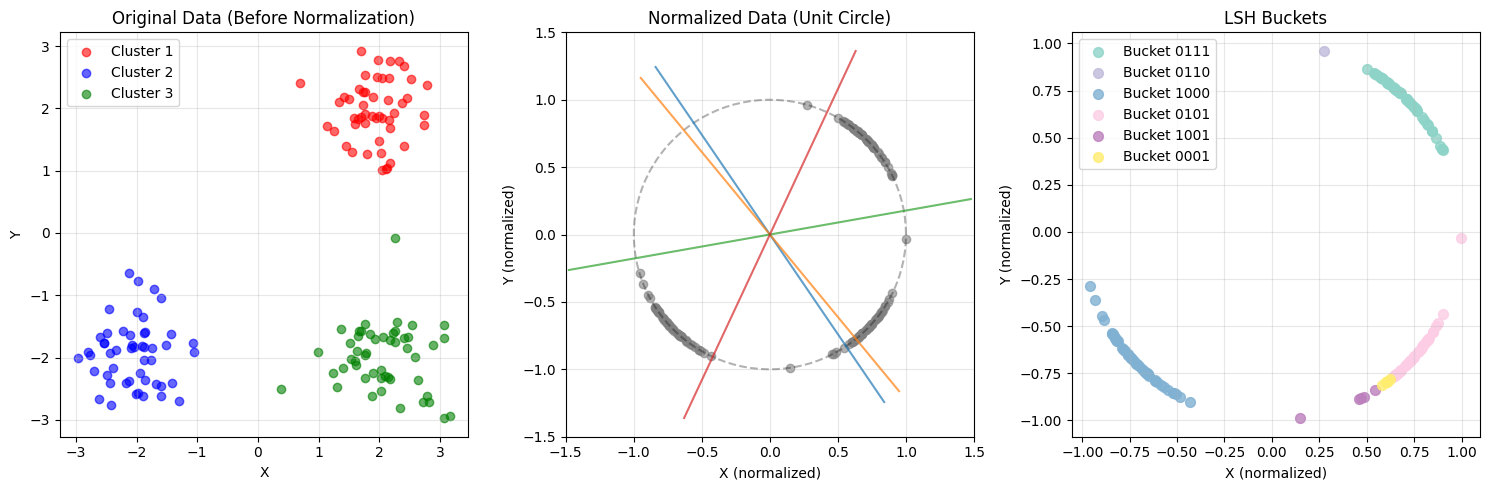


Bucket Analysis:
Bucket 0111: 49 points
  Average cosine distance within bucket: 0.024
Bucket 0110: 1 points
  Single point bucket
Bucket 1000: 50 points
  Average cosine distance within bucket: 0.032
Bucket 0101: 39 points
  Average cosine distance within bucket: 0.024
Bucket 1001: 5 points
  Average cosine distance within bucket: 0.027
Bucket 0001: 6 points
  Average cosine distance within bucket: 0.000


In [5]:
"""
Example 4: Visualizing LSH Behavior
Understanding how hash functions partition the space
"""

# Generate 2D data for visualization
np.random.seed(42)

# Create clusters of points
cluster1 = np.random.normal([2, 2], 0.5, (50, 2))
cluster2 = np.random.normal([-2, -2], 0.5, (50, 2))
cluster3 = np.random.normal([2, -2], 0.5, (50, 2))

data_2d = np.vstack([cluster1, cluster2, cluster3])

# Normalize for cosine similarity
data_2d_norm = data_2d / np.linalg.norm(data_2d, axis=1, keepdims=True)

print("=== LSH Visualization ===")

# Create LSH with fewer hyperplanes for visualization
lsh_vis = RandomHyperplaneLSH(num_hyperplanes=4, vector_dim=2)

# Hash all points and group by bucket
buckets = defaultdict(list)
hash_codes_vis = []

for i, point in enumerate(data_2d_norm):
    hash_code = lsh_vis.hash_vector(point)
    bucket = lsh_vis.hash_to_bucket(hash_code)
    buckets[bucket].append(i)
    hash_codes_vis.append(hash_code)

print(f"Number of unique buckets: {len(buckets)}")
print("Bucket sizes:", [len(bucket) for bucket in buckets.values()])

# Plot the results
plt.figure(figsize=(15, 5))

# Plot 1: Original data with cluster colors
plt.subplot(1, 3, 1)
colors = ['red', 'blue', 'green']
for i, cluster_data in enumerate([cluster1, cluster2, cluster3]):
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
               c=colors[i], alpha=0.6, label=f'Cluster {i+1}')
plt.title('Original Data (Before Normalization)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Normalized data
plt.subplot(1, 3, 2)
plt.scatter(data_2d_norm[:, 0], data_2d_norm[:, 1], c='gray', alpha=0.6)
plt.title('Normalized Data (Unit Circle)')
plt.xlabel('X (normalized)')
plt.ylabel('Y (normalized)')
plt.grid(True, alpha=0.3)

# Draw hyperplanes
theta = np.linspace(0, 2*np.pi, 100)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)
plt.plot(unit_circle_x, unit_circle_y, 'k--', alpha=0.3)

# Draw hyperplanes (lines through origin)
for i, hyperplane in enumerate(lsh_vis.hyperplanes):
    # Hyperplane normal vector
    normal = hyperplane / np.linalg.norm(hyperplane)
    # Perpendicular vector for the line
    perp = np.array([-normal[1], normal[0]])
    
    # Draw line
    line_points = np.array([-1.5 * perp, 1.5 * perp])
    plt.plot(line_points[:, 0], line_points[:, 1], 
             label=f'Hyperplane {i+1}', alpha=0.7)

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

# Plot 3: LSH buckets
plt.subplot(1, 3, 3)
bucket_colors = plt.cm.Set3(np.linspace(0, 1, len(buckets)))

for i, (bucket_id, point_indices) in enumerate(buckets.items()):
    bucket_points = data_2d_norm[point_indices]
    plt.scatter(bucket_points[:, 0], bucket_points[:, 1], 
               c=[bucket_colors[i]], label=f'Bucket {bucket_id}', 
               alpha=0.8, s=50)

plt.title('LSH Buckets')
plt.xlabel('X (normalized)')
plt.ylabel('Y (normalized)')
plt.grid(True, alpha=0.3)

# Show only a few legend entries to avoid clutter
if len(buckets) <= 8:
    plt.legend()

plt.tight_layout()
plt.show()

# Print bucket analysis
print("\nBucket Analysis:")
for bucket_id, point_indices in buckets.items():
    print(f"Bucket {bucket_id}: {len(point_indices)} points")
    
    # Calculate average distance within bucket
    if len(point_indices) > 1:
        bucket_points = data_2d_norm[point_indices]
        distances = []
        for i in range(len(bucket_points)):
            for j in range(i+1, len(bucket_points)):
                # Cosine distance = 1 - cosine similarity
                cos_sim = np.dot(bucket_points[i], bucket_points[j])
                cos_dist = 1 - cos_sim
                distances.append(cos_dist)
        
        avg_distance = np.mean(distances) if distances else 0
        print(f"  Average cosine distance within bucket: {avg_distance:.3f}")
    else:
        print("  Single point bucket")

In [6]:
"""
Example 5: Practical LSH for High-Dimensional Vectors
Multi-table LSH for better performance
"""

class MultiTableLSH:
    """
    LSH with multiple hash tables for improved recall
    """
    def __init__(self, num_tables, num_hyperplanes_per_table, vector_dim):
        self.num_tables = num_tables
        self.num_hyperplanes_per_table = num_hyperplanes_per_table
        self.vector_dim = vector_dim
        
        # Create multiple LSH instances
        self.lsh_tables = []
        for _ in range(num_tables):
            lsh = RandomHyperplaneLSH(num_hyperplanes_per_table, vector_dim)
            self.lsh_tables.append(lsh)
        
        # Hash tables to store data
        self.hash_tables = [defaultdict(list) for _ in range(num_tables)]
        
    def insert(self, vector, vector_id):
        """Insert vector into all hash tables"""
        for i, lsh in enumerate(self.lsh_tables):
            bucket = lsh.hash_to_bucket(lsh.hash_vector(vector))
            self.hash_tables[i][bucket].append(vector_id)
    
    def query(self, query_vector, max_candidates=None):
        """Query all tables and combine results"""
        all_candidates = set()
        
        for i, lsh in enumerate(self.lsh_tables):
            bucket = lsh.hash_to_bucket(lsh.hash_vector(query_vector))
            candidates = self.hash_tables[i].get(bucket, [])
            all_candidates.update(candidates)
        
        candidates_list = list(all_candidates)
        
        if max_candidates and len(candidates_list) > max_candidates:
            return candidates_list[:max_candidates]
        
        return candidates_list

# Test with high-dimensional data
print("=== Multi-Table LSH for High-Dimensional Vectors ===")

# Generate high-dimensional dataset
n_vectors = 5000
vector_dim = 300  # Similar to word embeddings
database_hd = np.random.randn(n_vectors, vector_dim)

# Normalize vectors
database_hd = database_hd / np.linalg.norm(database_hd, axis=1, keepdims=True)

# Create some similar vectors for testing
query_base = np.random.randn(vector_dim)
query_base = query_base / np.linalg.norm(query_base)

# Add some noise to create similar vectors
similar_vectors = []
for i in range(10):
    noise = np.random.randn(vector_dim) * 0.1  # Small noise
    similar_vec = query_base + noise
    similar_vec = similar_vec / np.linalg.norm(similar_vec)
    similar_vectors.append(similar_vec)

# Insert similar vectors into database
database_hd[:10] = similar_vectors

print(f"Database: {n_vectors} vectors, {vector_dim} dimensions")
print(f"First 10 vectors are similar to query")

# Test different configurations
configs = [
    {"tables": 1, "hyperplanes": 16, "name": "Single Table"},
    {"tables": 5, "hyperplanes": 16, "name": "Multi Table (5)"},
    {"tables": 10, "hyperplanes": 16, "name": "Multi Table (10)"},
]

for config in configs:
    print(f"\n--- {config['name']} ---")
    
    # Create and populate LSH
    start_time = time.time()
    multi_lsh = MultiTableLSH(
        num_tables=config["tables"],
        num_hyperplanes_per_table=config["hyperplanes"],
        vector_dim=vector_dim
    )
    
    for i, vector in enumerate(database_hd):
        multi_lsh.insert(vector, i)
    
    build_time = time.time() - start_time
    
    # Query
    start_time = time.time()
    candidates = multi_lsh.query(query_base, max_candidates=100)
    query_time = time.time() - start_time
    
    # Calculate recall (how many of the first 10 similar vectors were found)
    true_similar = set(range(10))
    found_similar = set(candidates) & true_similar
    recall = len(found_similar) / len(true_similar)
    
    print(f"Build time: {build_time:.3f}s")
    print(f"Query time: {query_time:.6f}s")
    print(f"Candidates found: {len(candidates)}")
    print(f"Similar vectors found: {len(found_similar)}/10")
    print(f"Recall: {recall:.3f}")
    print(f"First few candidates: {candidates[:20]}")

# Brute force comparison for reference
print(f"\n--- Brute Force Baseline ---")
start_time = time.time()

similarities = []
for i, vector in enumerate(database_hd):
    sim = np.dot(query_base, vector)
    similarities.append((sim, i))

similarities.sort(reverse=True)
top_10_similar = [idx for _, idx in similarities[:10]]

brute_force_time = time.time() - start_time

print(f"Query time: {brute_force_time:.6f}s")
print(f"Top 10 most similar: {top_10_similar}")
print(f"These should be indices 0-9 if our similar vectors are most similar")

# Verify similarity scores
print(f"\nSimilarity scores for first 10 vectors:")
for i in range(10):
    sim = np.dot(query_base, database_hd[i])
    print(f"Vector {i}: similarity = {sim:.4f}")

speedup = brute_force_time / query_time if 'query_time' in locals() else 0
print(f"\nSpeedup vs brute force: {speedup:.1f}x")

=== Multi-Table LSH for High-Dimensional Vectors ===
Database: 5000 vectors, 300 dimensions
First 10 vectors are similar to query

--- Single Table ---
Build time: 0.025s
Query time: 0.000021s
Candidates found: 0
Similar vectors found: 0/10
Recall: 0.000
First few candidates: []

--- Multi Table (5) ---
Build time: 0.131s
Query time: 0.000042s
Candidates found: 0
Similar vectors found: 0/10
Recall: 0.000
First few candidates: []

--- Multi Table (10) ---
Build time: 0.304s
Query time: 0.000058s
Candidates found: 2
Similar vectors found: 0/10
Recall: 0.000
First few candidates: [1619, 4470]

--- Brute Force Baseline ---
Query time: 0.005848s
Top 10 most similar: [7, 6, 1, 0, 9, 4, 5, 3, 8, 2]
These should be indices 0-9 if our similar vectors are most similar

Similarity scores for first 10 vectors:
Vector 0: similarity = 0.5264
Vector 1: similarity = 0.5285
Vector 2: similarity = 0.4365
Vector 3: similarity = 0.4767
Vector 4: similarity = 0.5055
Vector 5: similarity = 0.4775
Vector 6: 

---

## 7. LSH for Different Distance Metrics

### LSH Hash Function Families:

1. **Random Hyperplanes (Cosine Distance)**
   - Hash function: $h(v) = \text{sign}(a \cdot v)$ where $a$ is random hyperplane
   - Probability: $P(h(u) = h(v)) = 1 - \frac{\theta(u,v)}{\pi}$ where $\theta$ is angle between vectors

2. **MinHash (Jaccard Distance)**
   - For set similarity
   - Hash function: $h(S) = \min\{\pi(s) : s \in S\}$ where $\pi$ is random permutation
   - Probability: $P(h(A) = h(B)) = \frac{|A \cap B|}{|A \cup B|}$

3. **p-stable LSH ($L_p$ norms)**
   - For Euclidean ($L_2$) and Manhattan ($L_1$) distances
   - Hash function: $h(v) = \lfloor \frac{a \cdot v + b}{w} \rfloor$ where $a \sim N(0,1)$, $b \sim U[0,w]$

4. **Bit Sampling (Hamming Distance)**
   - Hash function: Select random bit positions
   - For binary vectors

### Choosing the Right LSH:
- **Text/Documents**: MinHash (Jaccard similarity)
- **Embeddings/Features**: Random Hyperplanes (Cosine similarity)  
- **Images/Spatial**: p-stable LSH (Euclidean distance)
- **Binary Features**: Bit Sampling (Hamming distance)

=== L2 LSH for Euclidean Distance ===
Generated 90 points in 3 clusters


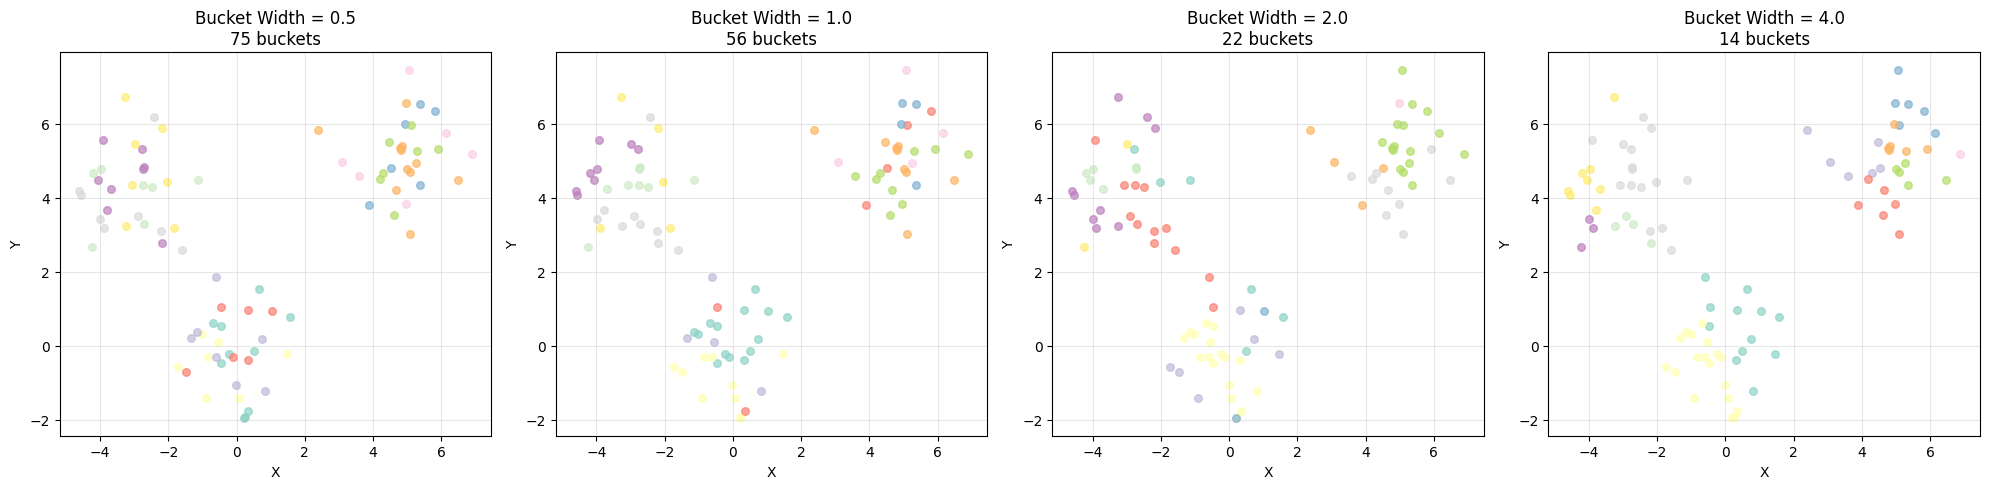


Bucket Analysis for different widths:
Width 0.5: 77 buckets, avg size  1.2, max size  3
Width 1.0: 70 buckets, avg size  1.3, max size  4
Width 2.0: 41 buckets, avg size  2.2, max size  8
Width 4.0: 19 buckets, avg size  4.7, max size 18

Query Performance Comparison
Query point: [1. 1.]
True 10-NN: [27, 3, 1, 29, 20, 0, 10, 23, 4, 25]

Bucket width 1.0:
  Candidates found: 0
  Candidates: []
  Recall: 0.000

Bucket width 2.0:
  Candidates found: 1
  Candidates: [27]
  Recall: 0.100
  Candidate distances: [('0.08', 27)]


In [7]:
"""
Example 6: p-stable LSH for Euclidean Distance
Using 2-stable (Gaussian) distributions for L2 norm
"""

class L2LSH:
    """
    LSH for Euclidean distance using 2-stable (Gaussian) distributions
    """
    def __init__(self, num_hash_functions, vector_dim, bucket_width=1.0):
        self.num_hash_functions = num_hash_functions
        self.vector_dim = vector_dim
        self.bucket_width = bucket_width
        
        # Random projection vectors (from Gaussian distribution)
        self.projections = np.random.randn(num_hash_functions, vector_dim)
        
        # Random offsets for each hash function
        self.offsets = np.random.uniform(0, bucket_width, num_hash_functions)
    
    def hash_vector(self, vector):
        """Hash vector using p-stable LSH"""
        # Project vector onto random directions
        projections = np.dot(self.projections, vector)
        
        # Add random offset and quantize
        hash_values = np.floor((projections + self.offsets) / self.bucket_width)
        
        return tuple(hash_values.astype(int))
    
    def hash_to_bucket(self, hash_code):
        """Convert hash code to bucket ID"""
        return '_'.join(map(str, hash_code))

# Example with 2D data for visualization
print("=== L2 LSH for Euclidean Distance ===")

# Create clusters in 2D space
np.random.seed(42)
cluster_centers = np.array([[0, 0], [5, 5], [-3, 4]])
clusters = []

for center in cluster_centers:
    cluster = np.random.normal(center, 1.0, (30, 2))
    clusters.append(cluster)

data_l2 = np.vstack(clusters)
n_points = len(data_l2)

print(f"Generated {n_points} points in 3 clusters")

# Test different bucket widths
bucket_widths = [0.5, 1.0, 2.0, 4.0]

plt.figure(figsize=(20, 5))

for i, bucket_width in enumerate(bucket_widths):
    plt.subplot(1, 4, i+1)
    
    # Create L2 LSH
    l2_lsh = L2LSH(num_hash_functions=4, vector_dim=2, bucket_width=bucket_width)
    
    # Hash all points
    buckets_l2 = defaultdict(list)
    for j, point in enumerate(data_l2):
        hash_code = l2_lsh.hash_vector(point)
        bucket = l2_lsh.hash_to_bucket(hash_code)
        buckets_l2[bucket].append(j)
    
    # Plot with bucket colors
    bucket_colors = plt.cm.Set3(np.linspace(0, 1, len(buckets_l2)))
    
    for k, (bucket_id, point_indices) in enumerate(buckets_l2.items()):
        bucket_points = data_l2[point_indices]
        plt.scatter(bucket_points[:, 0], bucket_points[:, 1], 
                   c=[bucket_colors[k]], alpha=0.7, s=30)
    
    plt.title(f'Bucket Width = {bucket_width}\n{len(buckets_l2)} buckets')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze bucket statistics
print("\nBucket Analysis for different widths:")
for bucket_width in bucket_widths:
    l2_lsh = L2LSH(num_hash_functions=4, vector_dim=2, bucket_width=bucket_width)
    
    buckets_l2 = defaultdict(list)
    for j, point in enumerate(data_l2):
        hash_code = l2_lsh.hash_vector(point)
        bucket = l2_lsh.hash_to_bucket(hash_code)
        buckets_l2[bucket].append(j)
    
    bucket_sizes = [len(bucket) for bucket in buckets_l2.values()]
    
    print(f"Width {bucket_width:3.1f}: {len(buckets_l2):2d} buckets, "
          f"avg size {np.mean(bucket_sizes):4.1f}, "
          f"max size {max(bucket_sizes):2d}")

# Compare with query performance
print("\n" + "="*50)
print("Query Performance Comparison")

query_point = np.array([1.0, 1.0])  # Query near first cluster

# Find true k-nearest neighbors using brute force
def euclidean_distance(p1, p2):
    return np.linalg.norm(p1 - p2)

distances = [(euclidean_distance(query_point, point), i) for i, point in enumerate(data_l2)]
distances.sort()
true_knn = [idx for _, idx in distances[:10]]

print(f"Query point: {query_point}")
print(f"True 10-NN: {true_knn}")

# Test LSH with different bucket widths
for bucket_width in [1.0, 2.0]:
    l2_lsh = L2LSH(num_hash_functions=8, vector_dim=2, bucket_width=bucket_width)
    
    # Build hash table
    hash_table_l2 = defaultdict(list)
    for j, point in enumerate(data_l2):
        hash_code = l2_lsh.hash_vector(point)
        bucket = l2_lsh.hash_to_bucket(hash_code)
        hash_table_l2[bucket].append(j)
    
    # Query
    query_hash = l2_lsh.hash_vector(query_point)
    query_bucket = l2_lsh.hash_to_bucket(query_hash)
    candidates = hash_table_l2.get(query_bucket, [])
    
    # Calculate recall
    recall = len(set(candidates) & set(true_knn)) / len(true_knn)
    
    print(f"\nBucket width {bucket_width}:")
    print(f"  Candidates found: {len(candidates)}")
    print(f"  Candidates: {candidates}")
    print(f"  Recall: {recall:.3f}")
    
    # Show distances of candidates
    if candidates:
        candidate_distances = [(euclidean_distance(query_point, data_l2[idx]), idx) for idx in candidates]
        candidate_distances.sort()
        print(f"  Candidate distances: {[(f'{dist:.2f}', idx) for dist, idx in candidate_distances[:5]]}")

## 8. Practical Considerations and Applications

### Parameter Tuning Guidelines:

1. **Number of Hash Functions (k)**:
   - More functions → Better precision, slower queries
   - Fewer functions → Better recall, more false positives
   - Typical range: 8-64 for most applications

2. **Number of Hash Tables (L)**:
   - More tables → Better recall, more memory usage
   - Typical range: 5-20 tables

3. **Bucket Width (for p-stable LSH)**:
   - Smaller width → More buckets, better precision
   - Larger width → Fewer buckets, better recall
   - Should be tuned based on data distribution

### Real-World Applications:

1. **Search Engines**: Document similarity, duplicate detection
2. **Recommendation Systems**: User-item similarity, collaborative filtering
3. **Computer Vision**: Image similarity, near-duplicate detection
4. **Bioinformatics**: DNA sequence similarity, protein structure comparison
5. **Social Networks**: Friend recommendation, community detection
6. **Databases**: Join operations, deduplication

### LSH in Vector Databases:
- **Preprocessing**: Build LSH index during data ingestion
- **Query Processing**: Use LSH for candidate generation, then refine with exact distance
- **Memory Management**: Balance between index size and query accuracy
- **Dynamic Updates**: Handle insertions/deletions efficiently

In [8]:
"""
Example 7: Complete LSH System with Parameter Tuning
Practical implementation with performance evaluation
"""

class AdaptiveLSH:
    """
    Adaptive LSH system that can tune parameters based on data characteristics
    """
    def __init__(self, vector_dim, distance_metric='cosine'):
        self.vector_dim = vector_dim
        self.distance_metric = distance_metric
        self.is_trained = False
        
    def train(self, sample_data, target_recall=0.8, max_candidates=100):
        """
        Train LSH parameters based on sample data
        """
        print("Training LSH parameters...")
        
        n_samples = min(1000, len(sample_data))  # Use subset for training
        training_data = sample_data[:n_samples]
        
        # Try different configurations
        configs = []
        
        if self.distance_metric == 'cosine':
            # Test random hyperplane LSH configurations
            for num_tables in [5, 10, 15]:
                for num_hyperplanes in [8, 16, 32]:
                    configs.append({
                        'type': 'hyperplane',
                        'num_tables': num_tables,
                        'num_hyperplanes': num_hyperplanes
                    })
        
        best_config = None
        best_score = 0
        
        for config in configs:
            # Evaluate configuration
            recall, precision, query_time = self._evaluate_config(
                config, training_data, target_recall, max_candidates
            )
            
            # Combined score: balance recall, precision, and speed
            score = recall * 0.5 + precision * 0.3 + (1.0 / (query_time + 1e-6)) * 0.2
            
            if score > best_score:
                best_score = score
                best_config = config
        
        self.best_config = best_config
        self.is_trained = True
        
        print(f"Best configuration found: {best_config}")
        return best_config
    
    def _evaluate_config(self, config, data, target_recall, max_candidates):
        """Evaluate a specific LSH configuration"""
        if config['type'] == 'hyperplane':
            # Create multi-table LSH
            lsh_system = MultiTableLSH(
                num_tables=config['num_tables'],
                num_hyperplanes_per_table=config['num_hyperplanes'],
                vector_dim=self.vector_dim
            )
            
            # Insert training data
            for i, vector in enumerate(data):
                lsh_system.insert(vector, i)
            
            # Test with random queries
            total_recall = 0
            total_precision = 0
            total_time = 0
            n_queries = min(50, len(data))
            
            for i in range(n_queries):
                query_vector = data[i]
                
                # Find true neighbors
                true_neighbors = self._find_true_neighbors(query_vector, data, k=20)
                
                # LSH query
                start_time = time.time()
                candidates = lsh_system.query(query_vector, max_candidates=max_candidates)
                query_time = time.time() - start_time
                
                # Calculate metrics
                if candidates and true_neighbors:
                    recall = len(set(candidates) & set(true_neighbors)) / len(true_neighbors)
                    precision = len(set(candidates) & set(true_neighbors)) / len(candidates)
                else:
                    recall = precision = 0
                
                total_recall += recall
                total_precision += precision
                total_time += query_time
            
            avg_recall = total_recall / n_queries
            avg_precision = total_precision / n_queries
            avg_time = total_time / n_queries
            
            return avg_recall, avg_precision, avg_time
        
        return 0, 0, float('inf')
    
    def _find_true_neighbors(self, query_vector, data, k=20):
        """Find true k-nearest neighbors"""
        similarities = []
        
        for i, vector in enumerate(data):
            if self.distance_metric == 'cosine':
                sim = np.dot(query_vector, vector) / (
                    np.linalg.norm(query_vector) * np.linalg.norm(vector)
                )
            else:  # euclidean
                sim = -np.linalg.norm(query_vector - vector)
            
            similarities.append((sim, i))
        
        similarities.sort(reverse=True)
        return [idx for _, idx in similarities[:k]]

# Test the adaptive LSH system
print("=== Adaptive LSH System ===")

# Generate test dataset
np.random.seed(42)
n_vectors = 2000
vector_dim = 100

# Create structured data with clusters
cluster_centers = np.random.randn(5, vector_dim)
data_adaptive = []

for center in cluster_centers:
    cluster_size = n_vectors // 5
    cluster_data = np.random.normal(center, 0.5, (cluster_size, vector_dim))
    data_adaptive.extend(cluster_data)

data_adaptive = np.array(data_adaptive)

# Normalize for cosine similarity
data_adaptive = data_adaptive / np.linalg.norm(data_adaptive, axis=1, keepdims=True)

print(f"Dataset: {len(data_adaptive)} vectors, {vector_dim} dimensions")

# Train adaptive LSH
adaptive_lsh = AdaptiveLSH(vector_dim=vector_dim, distance_metric='cosine')
best_config = adaptive_lsh.train(data_adaptive, target_recall=0.8, max_candidates=50)

# Build final LSH system with best configuration
print("\nBuilding final LSH system...")
final_lsh = MultiTableLSH(
    num_tables=best_config['num_tables'],
    num_hyperplanes_per_table=best_config['num_hyperplanes'],
    vector_dim=vector_dim
)

# Insert all data
start_time = time.time()
for i, vector in enumerate(data_adaptive):
    final_lsh.insert(vector, i)
build_time = time.time() - start_time

print(f"Build time: {build_time:.3f}s")

# Test queries
print("\nTesting final system:")
n_test_queries = 10
total_recall = 0
total_query_time = 0

for i in range(n_test_queries):
    query_idx = np.random.randint(0, len(data_adaptive))
    query_vector = data_adaptive[query_idx]
    
    # True neighbors
    true_neighbors = adaptive_lsh._find_true_neighbors(query_vector, data_adaptive, k=20)
    
    # LSH query
    start_time = time.time()
    candidates = final_lsh.query(query_vector, max_candidates=50)
    query_time = time.time() - start_time
    
    # Calculate recall
    recall = len(set(candidates) & set(true_neighbors)) / len(true_neighbors)
    
    total_recall += recall
    total_query_time += query_time
    
    if i < 3:  # Show details for first few queries
        print(f"Query {i+1}: {len(candidates)} candidates, recall={recall:.3f}, time={query_time:.6f}s")

avg_recall = total_recall / n_test_queries
avg_query_time = total_query_time / n_test_queries

print(f"\nFinal Performance:")
print(f"Average recall: {avg_recall:.3f}")
print(f"Average query time: {avg_query_time:.6f}s")
print(f"Configuration: {best_config}")

# Memory usage estimation
memory_usage = 0
for hash_table in final_lsh.hash_tables:
    memory_usage += len(hash_table) * 50  # Rough estimate in bytes

print(f"Estimated memory usage: {memory_usage / 1024:.1f} KB")

=== Adaptive LSH System ===
Dataset: 2000 vectors, 100 dimensions
Training LSH parameters...
Best configuration found: {'type': 'hyperplane', 'num_tables': 5, 'num_hyperplanes': 16}

Building final LSH system...
Build time: 0.047s

Testing final system:
Query 1: 11 candidates, recall=0.050, time=0.000086s
Query 2: 50 candidates, recall=0.250, time=0.000076s
Query 3: 21 candidates, recall=0.050, time=0.000080s

Final Performance:
Average recall: 0.185
Average query time: 0.000075s
Configuration: {'type': 'hyperplane', 'num_tables': 5, 'num_hyperplanes': 16}
Estimated memory usage: 175.6 KB


## 9. Summary and Best Practices

### Key Takeaways:

1. **LSH trades accuracy for speed**: Perfect for approximate nearest neighbor search
2. **Hash collisions are desired**: Similar items should hash to same buckets
3. **Multiple hash tables improve recall**: OR operation across tables
4. **Parameter tuning is crucial**: Balance precision, recall, and performance

### Best Practices:

#### Data Preparation:
- **Normalize vectors** for cosine similarity
- **Handle sparse data** appropriately (MinHash for sets)
- **Preprocess high-dimensional data** (dimensionality reduction if needed)

#### Parameter Selection:
- **Start with fewer hash functions** and increase if precision is low
- **Use multiple tables** (5-20) for better recall
- **Tune bucket width** for p-stable LSH based on data distribution
- **Validate on held-out data** before production

#### Implementation:
- **Use existing libraries** (datasketch, FALCONN, etc.) when possible
- **Implement incremental updates** for dynamic datasets  
- **Monitor performance metrics** in production
- **Consider hybrid approaches** (LSH + exact search for refinement)

#### When to Use LSH:
✅ **Good for**: High-dimensional data, approximate search, large datasets
❌ **Not ideal for**: Low-dimensional data (<10D), exact search requirements

### Alternatives to Consider:
- **Hierarchical Navigable Small World (HNSW)**: Better accuracy, more complex
- **Inverted File Index (IVF)**: Good for moderate dimensions
- **Product Quantization (PQ)**: Excellent compression, good for memory-constrained systems
- **Random Projection Trees**: Good for moderate dimensions

## 10. References and Further Reading

### Academic Papers:
1. **Indyk, P. & Motwani, R. (1998)** - "Approximate nearest neighbors: towards removing the curse of dimensionality"
2. **Gionis, A., Indyk, P. & Motwani, R. (1999)** - "Similarity Search in High Dimensions via Hashing"
3. **Datar, M., et al. (2004)** - "Locality-sensitive hashing scheme based on p-stable distributions"
4. **Broder, A. (1997)** - "On the resemblance and containment of documents"

### Practical Resources:
- **DataSketch Library**: https://github.com/ekzhu/datasketch
- **FALCONN**: https://github.com/FALCONN-LIB/FALCONN  
- **Annoy**: https://github.com/spotify/annoy
- **FAISS**: https://github.com/facebookresearch/faiss

### Books:
- **"Mining of Massive Datasets"** by Leskovec, Rajaraman & Ullman (Chapter 3)
- **"Introduction to Information Retrieval"** by Manning, Raghavan & Schütze

### Online Courses:
- **Stanford CS246**: Mining Massive Data Sets
- **MIT 6.854**: Advanced Algorithms

### Applications in Industry:
- **Google**: Web search duplicate detection
- **Spotify**: Music recommendation (Annoy)
- **Facebook**: Image similarity (FAISS)
- **Netflix**: Content recommendation

In [9]:
"""
Exercise: Implement your own LSH variant

Try implementing one of these variants:
1. LSH for binary vectors (Hamming distance)
2. LSH with learned hash functions
3. Dynamic LSH that adapts to data distribution
4. LSH with quality guarantees

Example starter code for Hamming distance LSH:
"""

class HammingLSH:
    """LSH for binary vectors using random bit sampling"""
    
    def __init__(self, num_bits, vector_length):
        self.num_bits = num_bits
        self.vector_length = vector_length
        # Random bit positions to sample
        self.bit_positions = np.random.choice(vector_length, num_bits, replace=False)
    
    def hash_vector(self, binary_vector):
        """Hash binary vector by sampling specific bit positions"""
        return tuple(binary_vector[self.bit_positions])

# Test with random binary data
print("=== Exercise: Hamming Distance LSH ===")

# Generate random binary vectors
n_vectors = 100
vector_length = 50
binary_data = np.random.randint(0, 2, (n_vectors, vector_length))

print(f"Generated {n_vectors} binary vectors of length {vector_length}")

# Create Hamming LSH
hamming_lsh = HammingLSH(num_bits=10, vector_length=vector_length)

# Hash all vectors
hamming_buckets = defaultdict(list)
for i, vector in enumerate(binary_data):
    hash_code = hamming_lsh.hash_vector(vector)
    bucket = '_'.join(map(str, hash_code))
    hamming_buckets[bucket].append(i)

print(f"Created {len(hamming_buckets)} buckets")
bucket_sizes = [len(bucket) for bucket in hamming_buckets.values()]
print(f"Average bucket size: {np.mean(bucket_sizes):.2f}")
print(f"Bucket size distribution: min={min(bucket_sizes)}, max={max(bucket_sizes)}")

# Test query
query_vector = binary_data[0]  # Use first vector as query
query_hash = hamming_lsh.hash_vector(query_vector)
query_bucket = '_'.join(map(str, query_hash))
candidates = hamming_buckets.get(query_bucket, [])

print(f"\nQuery test:")
print(f"Query vector: {query_vector[:20]}...")  # Show first 20 bits
print(f"Found {len(candidates)} candidates in same bucket: {candidates}")

# Calculate actual Hamming distances
if len(candidates) > 1:
    print("\nHamming distances to candidates:")
    for candidate_idx in candidates[:5]:  # Show first 5
        if candidate_idx != 0:  # Skip query itself
            hamming_dist = np.sum(query_vector != binary_data[candidate_idx])
            print(f"  Vector {candidate_idx}: distance = {hamming_dist}")

print("\n" + "="*50)
print("Next Steps:")
print("1. Experiment with different LSH parameters")
print("2. Try LSH on your own datasets")  
print("3. Compare LSH with other indexing methods (HNSW, IVF)")
print("4. Explore advanced topics: learning-based LSH, quantum LSH")
print("5. Implement LSH in production systems")

print("\nCongratulations! You've completed the LSH tutorial! 🎉")

=== Exercise: Hamming Distance LSH ===
Generated 100 binary vectors of length 50
Created 94 buckets
Average bucket size: 1.06
Bucket size distribution: min=1, max=2

Query test:
Query vector: [0 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1]...
Found 1 candidates in same bucket: [0]

Next Steps:
1. Experiment with different LSH parameters
2. Try LSH on your own datasets
3. Compare LSH with other indexing methods (HNSW, IVF)
4. Explore advanced topics: learning-based LSH, quantum LSH
5. Implement LSH in production systems

Congratulations! You've completed the LSH tutorial! 🎉
